In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

import openpyxl

from Fun_RioWholeModel import (GetScan,Run_model_w_dry_out ,Run_model_wo_Dry_out,Cal_new_con_Update,Run_Model_Base_On_Last_Solution,Run_Model_Base_On_Last_Solution_RPT,write_excel_xlsx,)
import multiprocessing

# Get global setting:
for i in range(0,1):  
    Total_Cycles = 4; Cycle_bt_RPT = 2; Update_Cycles = 2;  
    CyclePack = [Total_Cycles,Cycle_bt_RPT,Update_Cycles];
    # Key scan parameters:
    Ratio_excess = [1.04,];
    cs_Neg_Init = [29866,]; Diff_SEI = [1.7e-20,];     # default: 29866
    R_SEI = [2E5,];   Bulk_Sol_Con =[ 4541.0,];
    D_Li_inSEI = [1e-16, ];    # default: 1e-20 
    c_Li_inte_ref = [15,];    # default: 15
    Couple_SEI_LiP = [1e-6,]; # default: 1e-6
    k_LiP = [1E-10];         # default: 1e-10
    Temper = [25,];
    MESH_PAR = [30,];

    (TotalScan, DatePack_scan) = GetScan(Ratio_excess,cs_Neg_Init,Diff_SEI,
        R_SEI,Bulk_Sol_Con,D_Li_inSEI,c_Li_inte_ref,Couple_SEI_LiP,k_LiP,Temper,MESH_PAR);
    BasicPath = 'D:/OneDrive - Imperial College London/PhD Study/Imperial Study/Model/Pybamm Learning/SimDataSave/2nd paper';  
    Target = 'Acer_MakeMoreSEI_220722/';   
    if not os.path.exists(BasicPath + Target):
        os.mkdir(BasicPath + Target);
    book_name_xlsx = 'Inte_SEI_1170cycles.xlsx';

    sheet_name_xlsx = 'Results'
    value3 = [
        ["Index", "Ratio_ex","cs_Neg_Init", "Diff_SEI", "R_SEI", 
        "Bulk_Sol_Con","D_Li_inSEI", "c_Li_inte_ref",
        "Couple_SEI_LiP","k_LiP","Temper_i","mesh_par",
        "Cap Loss","LLI to LiP",
        "LLI to SEI","Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final"],
        ]
    write_excel_xlsx(BasicPath + Target+book_name_xlsx, sheet_name_xlsx, value3)


Successfully create a excel file


In [2]:
DatePack_scan_i = DatePack_scan[0];

In [3]:
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 
(Total_Cycles, Cycle_bt_RPT, Update_Cycles ) = CyclePack;
Small_Loop =  int(Cycle_bt_RPT/Update_Cycles);   SaveTimes = int(Total_Cycles/Cycle_bt_RPT);   RPT_Cycles = 1; 
#index 
ModelTimer = pb.Timer()
# unpack data:
[index_xlsx,
Ratio_excess_i,
cs_Neg_Init_i,
Diff_SEI_i,
R_SEI_i,
Bulk_Sol_Con_i,
D_Li_inSEI_i,
c_Li_inte_ref_i,
Couple_SEI_LiP_i,
k_LiP_i,
Temper_i,
mesh_par,
] = DatePack_scan_i;
count_i = int(index_xlsx);
#
Experiment_Long   = pb.Experiment(  [(f"Discharge at 1 C until {V_min} V", f"Charge at 0.3 C until {V_max} V", f"Hold at {V_max} V until C/100"),  ] * Update_Cycles  )  
Experiment_RPT    = pb.Experiment( [ (f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" ) ] * RPT_Cycles ) 
Experiment_Breakin= pb.Experiment( [ ( f"Discharge at 0.1C until {V_min} V",  "Rest for 6 hours",  f"Charge at 0.1C until {V_max} V" )  ] *2 )

sheet_name_xlsx = 'Results';
################ Important: index definition #################################
index = list(np.arange(1,SaveTimes+1)*(Small_Loop+RPT_Cycles)-1); #index.insert(0,0)  # get all last ageing cycle before RPT, plus the first RPT test
index2= list(np.arange(0,SaveTimes+1)*(Small_Loop+RPT_Cycles));         # get all RPT test
cycles = np.arange(0,SaveTimes+1)*Cycle_bt_RPT; 
cycles3 = list(np.arange(1,SaveTimes+1)*(Cycle_bt_RPT));
#try:             
for i in range(0,1):    ######################   update parameter and run first RPT
    ChemistryChen=pb.parameter_sets.Chen2020_coupled
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"   
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Upper voltage cut-off [V]": 4.21})
    Para_0.update({"Lower voltage cut-off [V]": 2.49})
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": 2e-13})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": 1e-13})
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init_i })
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})                
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_0 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"interstitial-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: int(mesh_par),  var.r_p: int(mesh_par),  }
    
    Sim_0    = pb.Simulation(
        Model_0,        experiment = Experiment_Breakin,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        var_pts=var_pts,) #mode="safe"
    Sol_0    = Sim_0.solve()

for i in range(0,1):    ######################   initialize for post-processing before running subsequent model   
    Vol_Elely_Tot_All  = [];       Vol_Elely_JR_All =[];         Vol_Pore_tot_All =[];
    Ratio_CeEC_All     = [];       Ratio_CeLi_All = [];          Ratio_Dryout_All =[];
    Vol_EC_consumed_All= [];       Vol_Elely_need_All = [];      Width_all        =[];
    Vol_Elely_add_All  = [];       Vol_Pore_decrease_All =[];
    Para_All           = [];       Model_All = [];               Sol_All_i =[]  ;    
    Test_V_All=[];    Test_V2_All=[]; c_e_r_new_All=[]; c_EC_r_new_All=[]; 
    # for RPT:
    Cap_RPT_Dry_All=[]; CapLoss_LiP_Dry_All=[]; R_Local_ECM_Dry_All =[]; 
    NegSOC_CCend_Dry_All =[];  NegSOC_CDend_Dry_All =[];  PosSOC_CCend_Dry_All =[]; PosSOC_CDend_Dry_All =[];
    CapLoss_SEI_Dry_All=[];         Cap_Pos_Dry_All=[];          Cap_Neg_Dry_All=[]; 


    T_0                  =  Para_0['Initial temperature [K]']
    Porosity_Neg_0       =  Para_0['Negative electrode porosity']  
    Porosity_Pos_0       =  Para_0['Positive electrode porosity']  
    Porosity_Sep_0       =  Para_0['Separator porosity']  
    cs_Neg_Max           =  Para_0["Maximum concentration in negative electrode [mol.m-3]"];
    L_p                  =  Para_0["Positive electrode thickness [m]"]
    L_n                  =  Para_0["Negative electrode thickness [m]"]
    L_s                  =  Para_0["Separator thickness [m]"]
    L_y_0                =  Para_0["Initial Electrode width [m]"]
    L_z_0                =  Para_0["Initial Electrode height [m]"]
    Int_ElelyExces_Ratio =  Para_0["Initial electrolyte excessive amount ratio"] 
    Vol_Elely_Tot        =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0 * Int_ElelyExces_Ratio # Set initial electrolyte amount [L] 
    Vol_Elely_JR         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
    Vol_Pore_tot         =  ( L_n*Porosity_Neg_0 +  L_p*Porosity_Pos_0  +  L_s*Porosity_Sep_0  )  * L_y_0 * L_z_0
    Ratio_CeEC           =  1.0   
    Ratio_CeLi           =  1.0   
    Ratio_Dryout         =  1.0
    Vol_EC_consumed      =  0
    Vol_Elely_need       =  0
    Vol_Elely_add        =  0
    Vol_Pore_decrease    =  0
    print('Initial electrolyte amount is ', Vol_Elely_Tot*1e6, 'mL') 
    Para_0.update({'Current total electrolyte volume in jelly roll [m3]':Vol_Elely_JR})
    Para_0.update({'Current total electrolyte volume in whole cell [m3]':Vol_Elely_Tot})   
    Vol_Elely_Tot_All.append(Vol_Elely_Tot*1e6);            Vol_Elely_JR_All.append(Vol_Elely_JR*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot*1e6);           
    Ratio_CeEC_All.append(Ratio_CeEC);                      Ratio_CeLi_All.append(Ratio_CeLi);             Ratio_Dryout_All.append(Ratio_Dryout);
    Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);        Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(L_y_0);
    Vol_Elely_add_All.append(Vol_Elely_add*1e6);            Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
    c_e_r_new_All.append(1000.0); c_EC_r_new_All.append(Bulk_Sol_Con_i); 

for i in range(0,1):    #################### post process for the first RPT cycle    ############################
    Cap_RPT_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_0.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
    CapLoss_LiP_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
    CapLoss_SEI_Dry_All.append(Sol_0.cycles[-1].steps[0]["Loss of capacity to negative electrode SEI [A.h]"].entries[-1])
    R_Local_ECM_Dry_All.append(Sol_0.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
    NegSOC_CCend_Dry_All .append(Sol_0.cycles[-1].steps[-1]["Negative electrode SOC"].entries[-1]);  
    NegSOC_CDend_Dry_All .append(Sol_0.cycles[-1].steps[0]["Negative electrode SOC"].entries[-1]);  
    PosSOC_CCend_Dry_All .append(Sol_0.cycles[-1].steps[-1]["Positive electrode SOC"].entries[-1]); 
    PosSOC_CDend_Dry_All .append(Sol_0.cycles[-1].steps[0]["Positive electrode SOC"].entries[-1]);  

    Cap_Pos_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
    Cap_Neg_Dry_All.append    (Sol_0.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])    

    Epsilon_CCend_Dry_First = Sol_0.cycles[-1].steps[-1]["Porosity"].entries[:,-1]
    j_Neg_Int_CCend_Dry_First = Sol_0.cycles[-1].steps[-1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] 
    Eta_Elely_CCend_Dry_First = Sol_0.cycles[-1].steps[-1]["Electrolyte potential [V]"].entries[:,-1] 
    Eta_Neg_rec_CCend_Dry_First = Sol_0.cycles[-1].steps[-1]["Negative electrode reaction overpotential [V]"].entries[:,-1] 
    c_s_Neg_Surf_CCend_Dry_First = Sol_0.cycles[-1].steps[-1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] 
    
    Epsilon_CDend_Dry_First = Sol_0.cycles[-1].steps[0]["Porosity"].entries[:,-1]
    j_Neg_Int_CDend_Dry_First = Sol_0.cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] 
    Eta_Elely_CDend_Dry_First = Sol_0.cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] 
    Eta_Neg_rec_CDend_Dry_First = Sol_0.cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] 
    c_s_Neg_Surf_CDend_Dry_First = Sol_0.cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] 


x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];   # Get location variable, can be any single solution

# Para_All.append(Para_0);                                Model_All.append(Model_0);    Sol_All_i.append(Sol_0); 
Para_0_Dry_old = Para_0;     Model_Dry_old = Model_0  ; Sol_Dry_old = Sol_0    ;   del Model_0,Sol_0,Para_0
#Step3: Write a big loop to finish the long experiment,    
Index_update_all     =[]; cycle_count =0; Index_update_all.append(cycle_count);
k=0; 
while k < SaveTimes:    # biggest loop, 
    i=0;     cap_i = 0;
    while i < Small_Loop:
        # run ageing cycles, and update parameters (have another version not update)
        Data_Pack,Paraupdate   = Cal_new_con_Update (  Sol_Dry_old,   Para_0_Dry_old )
        [
            Vol_EC_consumed, 
            Vol_Elely_need, 
            Test_V, 
            Test_V2, 
            Vol_Elely_add, 
            Vol_Elely_Tot_new, 
            Vol_Elely_JR_new, 
            Vol_Pore_tot_new, 
            Vol_Pore_decrease, 
            c_e_r_new, c_EC_r_new,
            Ratio_Dryout, Ratio_CeEC_JR, 
            Ratio_CeLi_JR,
            Width_new, ]= Data_Pack;
        # Append single object to All object     
        Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
        Ratio_CeEC_All.append(Ratio_CeEC_JR);               Ratio_CeLi_All.append(Ratio_CeLi_JR);                 Ratio_Dryout_All.append(Ratio_Dryout);
        Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
        Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6);
        Test_V_All.append(Test_V*1e6); Test_V2_All.append(Test_V2*1e6); 
        c_e_r_new_All.append(c_e_r_new); c_EC_r_new_All.append(c_EC_r_new); 

        # 3rd: run model based on new parameter and last updated solution Model  , Sol, Ratio_CeLi, Para_update, ModelExperiment, SaveAs_Cycles
        Model_Dry_i, Sol_Dry_i   = Run_Model_Base_On_Last_Solution( 
            Model_Dry_old  , Sol_Dry_old ,  
            Paraupdate ,Experiment_Long, Update_Cycles,Temper_i,mesh_par )
        Para_0_Dry_old = Paraupdate;       Model_Dry_old = Model_Dry_i;      Sol_Dry_old = Sol_Dry_i;   
        del Paraupdate,Model_Dry_i,Sol_Dry_i
        i += 1;   cycle_count +=  Update_Cycles; 
        Index_update_all.append(cycle_count);

    # run RPT, and also update parameters (otherwise will have problems)
    Data_Pack , Paraupdate  = Cal_new_con_Update (  Sol_Dry_old,   Para_0_Dry_old   )
    [
            Vol_EC_consumed, 
            Vol_Elely_need, 
            Test_V, 
            Test_V2, 
            Vol_Elely_add, 
            Vol_Elely_Tot_new, 
            Vol_Elely_JR_new, 
            Vol_Pore_tot_new, 
            Vol_Pore_decrease, 
            c_e_r_new, c_EC_r_new,
            Ratio_Dryout, Ratio_CeEC_JR, 
            Ratio_CeLi_JR,
            Width_new, ]= Data_Pack;
    # Append single object to All object     
    Vol_Elely_Tot_All.append(Vol_Elely_Tot_new*1e6);    Vol_Elely_JR_All.append(Vol_Elely_JR_new*1e6);     Vol_Pore_tot_All.append(Vol_Pore_tot_new*1e6);           
    Ratio_CeEC_All.append(Ratio_CeEC_JR);                  Ratio_CeLi_All.append(Ratio_CeLi_JR);                 Ratio_Dryout_All.append(Ratio_Dryout);
    Vol_EC_consumed_All.append(Vol_EC_consumed*1e6);    Vol_Elely_need_All.append(Vol_Elely_need*1e6);     Width_all.append(Width_new);
    Vol_Elely_add_All.append(Vol_Elely_add*1e6);        Vol_Pore_decrease_All.append(Vol_Pore_decrease*1e6); 
    Test_V_All.append(Test_V*1e6); Test_V2_All.append(Test_V2*1e6); 
    c_e_r_new_All.append(c_e_r_new); c_EC_r_new_All.append(c_EC_r_new); 

    Index_update_all.append(cycle_count);

    Model_Dry_i, Sol_Dry_i  = Run_Model_Base_On_Last_Solution_RPT( 
        Model_Dry_old  , Sol_Dry_old ,   
        Paraupdate,      Experiment_RPT, RPT_Cycles, Temper_RPT ,mesh_par )     
    for ii in range(0,1):     # add later RPT cycle 
        Cap_RPT_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[-1] - Sol_Dry_i.cycles[-1].steps[0]["Discharge capacity [A.h]"].entries[0])
        CapLoss_LiP_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of capacity to negative electrode lithium plating [A.h]"].entries[-1])
        CapLoss_SEI_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Loss of capacity to negative electrode SEI [A.h]"].entries[-1])
        R_Local_ECM_Dry_All.append(Sol_Dry_i.cycles[-1].steps[0]["Local ECM resistance [Ohm]"].entries[-1])
        NegSOC_CCend_Dry_All .append(Sol_Dry_i.cycles[-1].steps[-1]["Negative electrode SOC"].entries[-1]);  
        NegSOC_CDend_Dry_All .append(Sol_Dry_i.cycles[-1].steps[0]["Negative electrode SOC"].entries[-1]);  
        PosSOC_CCend_Dry_All .append(Sol_Dry_i.cycles[-1].steps[-1]["Positive electrode SOC"].entries[-1]); 
        PosSOC_CDend_Dry_All .append(Sol_Dry_i.cycles[-1].steps[0]["Positive electrode SOC"].entries[-1]);  
        Cap_Pos_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Positive electrode capacity [A.h]"].entries[-1])
        Cap_Neg_Dry_All.append    (Sol_Dry_i.cycles[-1].steps[0]["Negative electrode capacity [A.h]"].entries[-1])      
    if k == SaveTimes-1:  # Last RPT cycle
        Epsilon_CCend_Dry_Last =  Sol_Dry_i.cycles[-1].steps[-1]["Porosity"].entries[:,-1]
        j_Neg_Int_CCend_Dry_Last = Sol_Dry_i.cycles[-1].steps[-1]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] 
        Eta_Elely_CCend_Dry_Last = Sol_Dry_i.cycles[-1].steps[-1]["Electrolyte potential [V]"].entries[:,-1] 
        Eta_Neg_rec_CCend_Dry_Last = Sol_Dry_i.cycles[-1].steps[-1]["Negative electrode reaction overpotential [V]"].entries[:,-1] 
        c_s_Neg_Surf_CCend_Dry_Last = Sol_Dry_i.cycles[-1].steps[-1]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] 
        
        Epsilon_CDend_Dry_Last =  Sol_Dry_i.cycles[-1].steps[0]["Porosity"].entries[:,-1]
        j_Neg_Int_CDend_Dry_Last = Sol_Dry_i.cycles[-1].steps[0]["Negative electrode interfacial current density [A.m-2]"].entries[:,-1] 
        Eta_Elely_CDend_Dry_Last = Sol_Dry_i.cycles[-1].steps[0]["Electrolyte potential [V]"].entries[:,-1] 
        Eta_Neg_rec_CDend_Dry_Last = Sol_Dry_i.cycles[-1].steps[0]["Negative electrode reaction overpotential [V]"].entries[:,-1] 
        c_s_Neg_Surf_CDend_Dry_Last = Sol_Dry_i.cycles[-1].steps[0]["Negative particle surface concentration [mol.m-3]"].entries[:,-1] 

    Para_0_Dry_old = Paraupdate;    Model_Dry_old = Model_Dry_i  ;                 Sol_Dry_old = Sol_Dry_i    ;   del Paraupdate,Model_Dry_i,Sol_Dry_i
    k += 1
    #except:
    """ data = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx)         
    table = data.get_sheet_by_name('Results')
    nrows = table.max_row  # 获得行数
    ncolumns = table.max_column  # 获得列数
    values = [
        [count_i, Ratio_excess_i,cs_Neg_Init_i, Diff_SEI_i, R_SEI_i, 
        Bulk_Sol_Con_i,D_Li_inSEI_i, c_Li_inte_ref_i,
        Couple_SEI_LiP_i,k_LiP_i,Temper_i,mesh_par,
        "nan","nan",
        "nan","nan", "nan","nan"],
        ]
    for i in range(1, len(values)+1):
        for j in range(1, len(values[i-1])+1):
            table.cell(nrows+i, j).value = values[i-1][j-1]     
    data.save(BasicPath + Target + book_name_xlsx)
    print("Fail in {}".format(ModelTimer.time())) """
    #else:

Initial electrolyte amount is  5.582426928 mL
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)
Electrolyte is being squeezed out, check plated lithium (reversible part)


In [11]:
data = openpyxl.load_workbook(BasicPath + Target+ book_name_xlsx)         
table = data.get_sheet_by_name('Results')
nrows = table.max_row  # 获得行数
ncolumns = table.max_column  # 获得列数
values = [
    [count_i, Ratio_excess_i,
    cs_Neg_Init_i, Diff_SEI_i, R_SEI_i, 
    Bulk_Sol_Con_i,D_Li_inSEI_i, c_Li_inte_ref_i,
    Couple_SEI_LiP_i,k_LiP_i,Temper_i,mesh_par,
    Cap_RPT_Dry_All[-1],CapLoss_LiP_Dry_All[-1],
    CapLoss_SEI_Dry_All[-1],Vol_Elely_Tot_All[-1], Vol_Elely_JR_All[-1],Width_all[-1]],
    ]
for i in range(1, len(values)+1):
    for j in range(1, len(values[i-1])+1):
        table.cell(nrows+i, j).value = values[i-1][j-1]     
data.save(BasicPath + Target+ book_name_xlsx)
print("Succeed in {}".format(ModelTimer.time()))
print('This is the ', count_i, ' scan')
if not os.path.exists(BasicPath + Target + str(count_i)):
    os.mkdir(BasicPath + Target + str(count_i) );


Succeed in 10 minutes, 1 second
This is the  1  scan


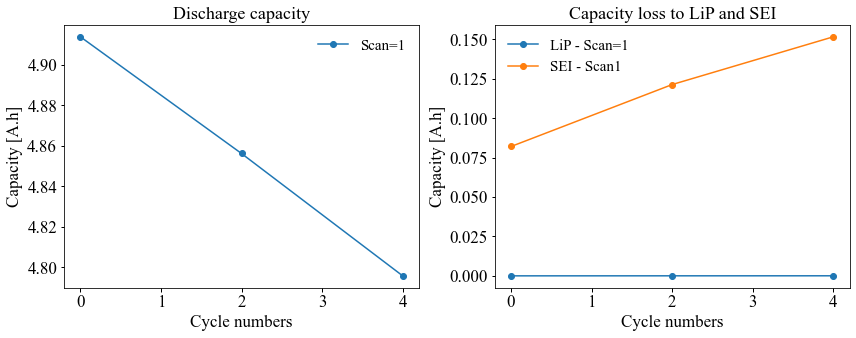

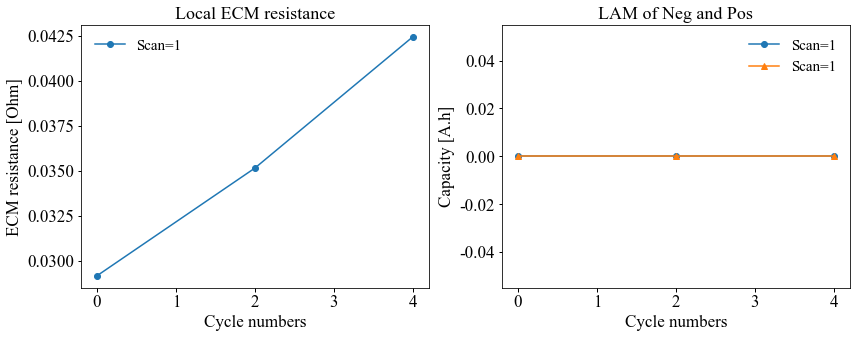

In [12]:
# Newly add (220517): save plots, not just a single line in excel file:     
# Fig. 1 how much capacity is loss, how much is due to SEI and LiP?
for mm in range(0,1):
    fs=17;Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[0].plot(cycles, Cap_RPT_Dry_All,     '-o', label="Scan=" + str(count_i) )
    axs[1].plot(cycles, CapLoss_LiP_Dry_All,'-o', label="LiP - Scan=" + str(count_i) )
    axs[1].plot(cycles, CapLoss_SEI_Dry_All ,'-o', label="SEI - Scan" + str(count_i) )
    for i in range(0,Num_subplot):
        axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_title("Discharge capacity",   fontdict={'family':'Times New Roman','size':fs+1})
    axs[1].set_title("Capacity loss to LiP and SEI",   fontdict={'family':'Times New Roman','size':fs+1})
    plt.savefig(BasicPath + Target+ str(count_i)+"/Cap-LLI.png", dpi=100)

    Num_subplot = 2;
    fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
    axs[1].plot(cycles, Cap_Neg_Dry_All[0]-Cap_Neg_Dry_All,'-o',label="Scan=" + str(count_i))
    axs[1].plot(cycles, Cap_Pos_Dry_All[0]-Cap_Pos_Dry_All   ,'-^',label="Scan=" + str(count_i))
    axs[0].plot(cycles, R_Local_ECM_Dry_All,                  '-o',label="Scan="+ str(count_i))
    for i in range(0,1):
        axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[0].set_ylabel("ECM resistance [Ohm]",   fontdict={'family':'Times New Roman','size':fs})
    axs[0].set_title("Local ECM resistance",   fontdict={'family':'Times New Roman','size':fs+1})
    for i in range(1,2):
        axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'Times New Roman','size':fs})
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
        axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
        axs[i].legend(prop={'family':'Times New Roman','size':fs-2},loc='best',frameon=False)
    axs[1].set_title("LAM of Neg and Pos",   fontdict={'family':'Times New Roman','size':fs+1})
    plt.savefig(BasicPath + Target+ str(count_i)+"/LAM-IR.png", dpi=100)


# Newly add (220706): save data, not just a single line in excel file:

for mm in range(0,1):
    CeEC_All =np.full(np.size(Ratio_CeEC_All),Bulk_Sol_Con_i); 
    for i in range(1,np.size(Ratio_CeEC_All)):
        for k in range(0,i):
            CeEC_All[i] *= Ratio_CeEC_All[k];        
mdic = {
    "x":x,
    "x_n":x_n,
    "cycles": cycles,
    "Cap_RPT_Dry_All": Cap_RPT_Dry_All,
    "Real_SaveAs_Cycles": CapLoss_LiP_Dry_All,
    "CapLoss_SEI_Dry_All": CapLoss_SEI_Dry_All,
    "SaveTimes": SaveTimes,
    "Cap_Neg_Dry_All": Cap_Neg_Dry_All,
    "Cap_Pos_Dry_All": Cap_Pos_Dry_All,
    "R_Local_ECM_Dry_All": R_Local_ECM_Dry_All,
    "NegSOC_CCend_Dry_All"  : NegSOC_CCend_Dry_All,
    "NegSOC_CDend_Dry_All"  : NegSOC_CDend_Dry_All,
    "PosSOC_CCend_Dry_All"  : PosSOC_CCend_Dry_All,
    "PosSOC_CDend_Dry_All"  : PosSOC_CDend_Dry_All,
    "CeEC_All": CeEC_All,
    "Vol_EC_consumed_All": Vol_EC_consumed_All,
    "c_EC_r_new_All": c_EC_r_new_All,
    "c_e_r_new_All": c_e_r_new_All,
    "Vol_Elely_Tot_All": Vol_Elely_Tot_All,
    "Vol_Elely_JR_All": Vol_Elely_JR_All,
    "Vol_Pore_tot_All": Vol_Pore_tot_All,
    "Epsilon_CCend_Dry_First":Epsilon_CCend_Dry_First,
    "j_Neg_Int_CCend_Dry_First":j_Neg_Int_CCend_Dry_First,
    "Eta_Elely_CCend_Dry_First":Eta_Elely_CCend_Dry_First,
    "Eta_Neg_rec_CCend_Dry_First":Eta_Neg_rec_CCend_Dry_First,
    "c_s_Neg_Surf_CCend_Dry_First":c_s_Neg_Surf_CCend_Dry_First,
    "Epsilon_CDend_Dry_First":Epsilon_CDend_Dry_First,
    "j_Neg_Int_CDend_Dry_First":j_Neg_Int_CDend_Dry_First,
    "Eta_Elely_CDend_Dry_First":Eta_Elely_CDend_Dry_First,
    "Eta_Neg_rec_CDend_Dry_First":Eta_Neg_rec_CDend_Dry_First,
    "c_s_Neg_Surf_CDend_Dry_First":c_s_Neg_Surf_CDend_Dry_First,
    "Epsilon_CCend_Dry_Last":Epsilon_CCend_Dry_Last,
    "j_Neg_Int_CCend_Dry_Last":j_Neg_Int_CCend_Dry_Last,
    "Eta_Elely_CCend_Dry_Last":Eta_Elely_CCend_Dry_Last,
    "Eta_Neg_rec_CCend_Dry_Last":Eta_Neg_rec_CCend_Dry_Last,
    "c_s_Neg_Surf_CCend_Dry_Last":c_s_Neg_Surf_CCend_Dry_Last,
    "Epsilon_CDend_Dry_Last":Epsilon_CDend_Dry_Last,
    "j_Neg_Int_CDend_Dry_Last":j_Neg_Int_CDend_Dry_Last,
    "Eta_Elely_CDend_Dry_Last":Eta_Elely_CDend_Dry_Last,
    "Eta_Neg_rec_CDend_Dry_Last":Eta_Neg_rec_CDend_Dry_Last,
    "c_s_Neg_Surf_CDend_Dry_Last":c_s_Neg_Surf_CDend_Dry_Last,
}
savemat(BasicPath + Target+ str(count_i) + '/' + str(count_i)+ '-StructDara_for_Mat.mat',mdic)   
    
